# Hybrid Wannier Centers and Edge States of the Haldane Model

In [1]:
# ------------------------------------------------------------
# Hybrid Wannier Centers and Edge States of the Haldane Model
# ------------------------------------------------------------

from __future__ import print_function # python3 style print
from pythtb import * # import TB model class

import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

In [2]:
# define setup of Haldane model
def set_model(delta,t,t2):
  lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
  orb=[[1./3.,1./3.],[2./3.,2./3.]]
  model=tb_model(2,2,lat,orb)
  model.set_onsite([-delta,delta])
  for lvec in ([ 0, 0], [-1, 0], [ 0,-1]):
    model.set_hop(t, 0, 1, lvec)
  for lvec in ([ 1, 0], [-1, 1], [ 0,-1]):
    model.set_hop(t2*1.j, 0, 0, lvec)
  for lvec in ([-1, 0], [ 1,-1], [ 0, 1]):
    model.set_hop(t2*1.j, 1, 1, lvec)
  return model


In [3]:
# set model parameters and construct bulk model
delta=0.7   # site energy shift
t=-1.0      # real first-neighbor hopping
nk=51

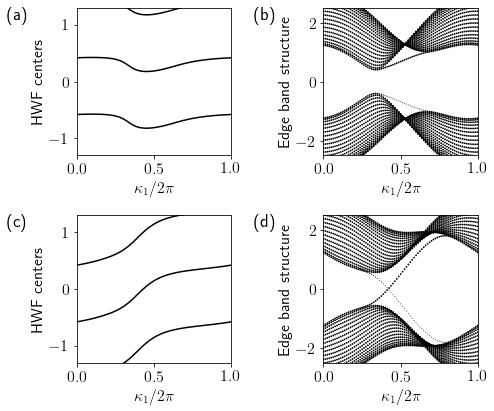

In [4]:
# For the purposes of plot labels:
#   Real space is (r1,r2) in reduced coordinates
#   Reciprocal space is (k1,k2) in reduced coordinates
# Below, following Python, these are (r0,r1) and (k0,k1)

# set up figures
fig,ax=plt.subplots(2,2,figsize=(7,6))

# run over two choices of t2
for j2,t2 in enumerate([-0.06,-0.24]):

  # solve bulk model on grid and get hybrid Wannier centers along r1
  # as a function of k0
  my_model=set_model(delta,t,t2)
  my_array=wf_array(my_model,[nk,nk])
  my_array.solve_on_grid([0.,0.])
  rbar_1 = my_array.berry_phase([0],1,contin=True)/(2.*np.pi)
  
  # set up and solve ribbon model that is finite along direction 1
  width=20
  nkr=81
  ribbon_model=my_model.cut_piece(width,fin_dir=1,glue_edgs=False)
  (k_vec,k_dist,k_node)=ribbon_model.k_path('full',nkr,report=False)
  (rib_eval,rib_evec)=ribbon_model.solve_all(k_vec,eig_vectors=True)
  
  nbands=rib_eval.shape[0]
  (ax0,ax1)=ax[j2,:]
  
  # hybrid Wannier center flow
  k0=np.linspace(0.,1.,nk)
  ax0.set_xlim(0.,1.)
  ax0.set_ylim(-1.3,1.3)
  ax0.set_xlabel(r"$\kappa_1/2\pi$")
  ax0.set_ylabel(r"HWF centers")
  for shift in (-2.,-1.,0.,1.):
    ax0.plot(k0,rbar_1+shift,color='k')
  
  # edge band structure
  k0=np.linspace(0.,1.,nkr)
  ax1.set_xlim(0.,1.)
  ax1.set_ylim(-2.5,2.5)
  ax1.set_xlabel(r"$\kappa_1/2\pi$")
  ax1.set_ylabel(r"Edge band structure")
  for (i,kv) in enumerate(k0):
  
    # find expectation value <r1> at i'th k-point along direction k0
    pos_exp=ribbon_model.position_expectation(rib_evec[:,i],dir=1)
  
    # assign weight in [0,1] to be 1 except for edge states near bottom
    weight=3.0*pos_exp/width
    for j in range(nbands):
      weight[j]=min(weight[j],1.)
  
    # scatterplot with symbol size proportional to assigned weight
    s=ax1.scatter([k_vec[i]]*nbands, rib_eval[:,i],
         s=0.6+2.5*weight, c='k', marker='o', edgecolors='none')

# save figure as a PDF
aa=ax.flatten()
for i,lab in enumerate(['(a)','(b)','(c)','(d)']):
  aa[i].text(-0.45,0.92,lab,size=18.,transform=aa[i].transAxes)
fig.tight_layout()
plt.subplots_adjust(left=0.15,wspace=0.6)
#fig.savefig("haldane_topo.pdf")

plt.show()